# RadarCOVID-Report

## Data Extraction

In [1]:
import datetime
import os
import shutil
import tempfile
import textwrap
import uuid

import dataframe_image as dfi
import matplotlib.ticker
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
sns.set()
matplotlib.rcParams['figure.figsize'] = (15, 6)

extraction_datetime = datetime.datetime.utcnow()
extraction_date = extraction_datetime.strftime("%Y-%m-%d")
extraction_previous_datetime = extraction_datetime - datetime.timedelta(days=1)
extraction_previous_date = extraction_previous_datetime.strftime("%Y-%m-%d")
extraction_date_with_hour = datetime.datetime.utcnow().strftime("%Y-%m-%d@%H")

### COVID-19 Cases

In [3]:
confirmed_df = pd.read_csv("https://covid19tracking.narrativa.com/csv/confirmed.csv")
confirmed_df = confirmed_df[confirmed_df["Country_EN"] == "Spain"]
confirmed_df = confirmed_df[pd.isna(confirmed_df["Region"])]
confirmed_country_columns = list(filter(lambda x: x.startswith("Country_"), confirmed_df.columns))
confirmed_regional_columns = confirmed_country_columns + ["Region"]
confirmed_df.drop(columns=confirmed_regional_columns, inplace=True)
confirmed_df = confirmed_df.transpose()
confirmed_df.reset_index(inplace=True)
confirmed_df.columns = ["sample_date_string", "cumulative_cases"]
confirmed_df.sort_values("sample_date_string", inplace=True)
confirmed_df["new_cases"] = confirmed_df.cumulative_cases.diff()
confirmed_df["rolling_mean_new_cases"] = confirmed_df.new_cases.rolling(7).mean()
confirmed_df.tail()

,sample_date_string,cumulative_cases,new_cases,rolling_mean_new_cases
217,2020-08-27,429507.0,9658.0,7371.571429
218,2020-08-28,439286.0,9779.0,7604.571429
219,2020-08-29,439286.0,0.0,7604.571429
220,2020-08-30,439286.0,0.0,7604.571429
221,2020-08-31,462858.0,23572.0,8203.142857


In [4]:
extraction_date_confirmed_df = \
    confirmed_df[confirmed_df.sample_date_string == extraction_date]
extraction_previous_date_confirmed_df = \
    confirmed_df[confirmed_df.sample_date_string == extraction_previous_date].copy()

if extraction_date_confirmed_df.empty and \
    not extraction_previous_date_confirmed_df.empty:
        extraction_previous_date_confirmed_df["sample_date_string"] = extraction_date
        extraction_previous_date_confirmed_df["new_cases"] = \
            extraction_previous_date_confirmed_df.rolling_mean_new_cases
        extraction_previous_date_confirmed_df["cumulative_cases"] = \
            extraction_previous_date_confirmed_df.new_cases + \
            extraction_previous_date_confirmed_df.cumulative_cases
        confirmed_df = confirmed_df.append(extraction_previous_date_confirmed_df)
        
confirmed_df.tail()

,sample_date_string,cumulative_cases,new_cases,rolling_mean_new_cases
218,2020-08-28,439286.000000,9779.000000,7604.571429
219,2020-08-29,439286.000000,0.000000,7604.571429
220,2020-08-30,439286.000000,0.000000,7604.571429
221,2020-08-31,462858.000000,23572.000000,8203.142857
221,2020-09-01,471061.142857,8203.142857,8203.142857


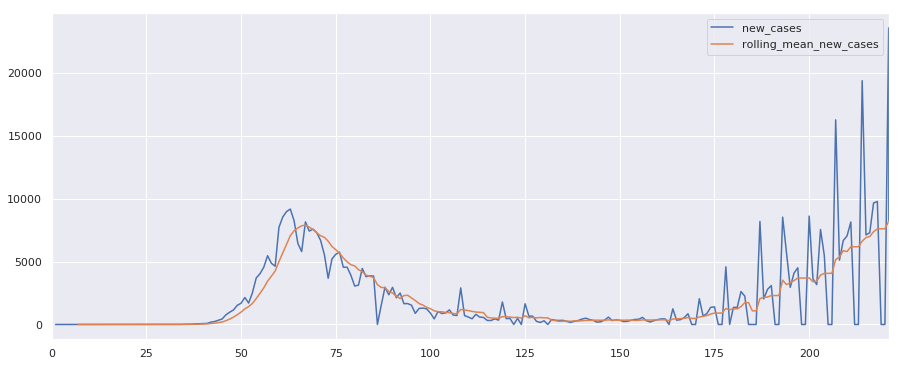

In [5]:
confirmed_df[["new_cases", "rolling_mean_new_cases"]].plot()

In [6]:
### RadarCOVID TEKs Extraction

In [7]:
from Modules.RadarCOVID import radar_covid

exposure_keys_df = radar_covid.download_last_radar_covid_exposure_keys(days=14)
exposure_keys_df[[
    "sample_date_string", "source_url", "region", "key_data"]].head()

,sample_date_string,source_url,region,key_data
0,2020-08-31,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,11f06c2a-b747-cdfa-7f8a-5aea966b3457
1,2020-08-31,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,0c96474c-afd3-c5b8-a692-2b510b9470ae
2,2020-08-31,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,cd5a0391-9122-e937-ed23-8e69c83d9f39
3,2020-08-31,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,83b70d50-22c6-919a-415f-7a5c43294ecb
4,2020-08-31,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,32ecafc1-f01f-ddce-6198-c2e5ea97fa97


In [8]:
exposure_keys_summary_df = \
    exposure_keys_df.groupby(["sample_date_string"]).key_data.nunique().to_frame()
exposure_keys_summary_df.sort_index(ascending=False, inplace=True)
exposure_keys_summary_df.rename(columns={"key_data": "tek_count"}, inplace=True)
exposure_keys_summary_df.head()

,tek_count
sample_date_string,
2020-08-31,7
2020-08-30,25
2020-08-29,28
2020-08-28,43
2020-08-27,65


### RadarCOVID TEKs Dump

In [9]:
tek_list_df = exposure_keys_df[["sample_date_string", "key_data"]].copy()
tek_list_df["key_data"] = tek_list_df["key_data"].apply(str)
tek_list_df.rename(columns={
    "sample_date_string": "sample_date",
    "key_data": "tek_list"}, inplace=True)
tek_list_df = tek_list_df.groupby(
    "sample_date").tek_list.unique().reset_index()
tek_list_df["extraction_date"] = extraction_date
tek_list_df["extraction_date_with_hour"] = extraction_date_with_hour
tek_list_df.to_json(
    "Data/TEKs/Daily/RadarCOVID-TEKs-" + extraction_date + ".json",
    lines=True, orient="records")
tek_list_df.to_json(
    "Data/TEKs/Hourly/RadarCOVID-TEKs-" + extraction_date_with_hour + ".json",
    lines=True, orient="records")
tek_list_df.head()

,sample_date,tek_list,extraction_date,extraction_date_with_hour
0,2020-08-19,[645572b7-c0e2-97bc-9bcb-7107fb5eb1bc],2020-09-01,2020-09-01@06
1,2020-08-20,"[5c4885a2-5c65-d6aa-8eed-7d607f106647, e6c3ca3...",2020-09-01,2020-09-01@06
2,2020-08-21,"[53c82402-7f1c-e203-7abc-593dc3a8a9fe, fd16f69...",2020-09-01,2020-09-01@06
3,2020-08-22,"[316fcc1d-9bdb-69ae-b997-70b5b4ca1d74, 33b23da...",2020-09-01,2020-09-01@06
4,2020-08-23,"[3dda2de2-fc66-33b9-cf6b-c7b85f8683d5, c0a53a0...",2020-09-01,2020-09-01@06


### RadarCOVID New TEKs

In [10]:
import glob

def load_extracted_teks(mode) -> pd.DataFrame:
    extracted_teks_df = pd.DataFrame()
    for path in glob.glob(f"Data/TEKs/{mode}/RadarCOVID-TEKs-*.json"):
        iteration_extracted_teks_df = pd.read_json(path, lines=True)
        extracted_teks_df = extracted_teks_df.append(
            iteration_extracted_teks_df, sort=False)
    return extracted_teks_df


In [11]:
### RadarCOVID Daily New TEKs

In [12]:
daily_extracted_teks_df = load_extracted_teks(mode="Daily")
daily_extracted_teks_df.head()

,sample_date,tek_list,extraction_date,extraction_date_with_hour
0,2020-08-19,[645572b7-c0e2-97bc-9bcb-7107fb5eb1bc],2020-08-29,NaN
1,2020-08-20,"[5c4885a2-5c65-d6aa-8eed-7d607f106647, e6c3ca3...",2020-08-29,NaN
2,2020-08-21,"[53c82402-7f1c-e203-7abc-593dc3a8a9fe, fd16f69...",2020-08-29,NaN
3,2020-08-22,"[316fcc1d-9bdb-69ae-b997-70b5b4ca1d74, 33b23da...",2020-08-29,NaN
4,2020-08-23,"[3dda2de2-fc66-33b9-cf6b-c7b85f8683d5, c0a53a0...",2020-08-29,NaN


In [13]:
tek_list_df = daily_extracted_teks_df.groupby("extraction_date").tek_list.apply(
    lambda x: set(sum(x, []))).reset_index()
tek_list_df = tek_list_df.set_index("extraction_date").sort_index(ascending=True)
tek_list_df.head()

,tek_list
extraction_date,
2020-08-29,"{303808c7-4995-b743-dcb9-59fc73fe9a12, 11035b8..."
2020-08-30,"{43943f8d-4696-3507-3b8d-b7a59c9b533a, 303808c..."
2020-08-31,"{43943f8d-4696-3507-3b8d-b7a59c9b533a, ad86f47..."
2020-09-01,"{43943f8d-4696-3507-3b8d-b7a59c9b533a, ad86f47..."


In [14]:
new_tek_df = tek_list_df.diff().tek_list.apply(
    lambda x: len(x) if not pd.isna(x) else None).to_frame().reset_index()
new_tek_df.rename(columns={
    "tek_list": "new_tek_count",
    "extraction_date": "sample_date_string",}, inplace=True)
new_tek_df.head()

,sample_date_string,new_tek_count
0,2020-08-29,NaN
1,2020-08-30,29.0
2,2020-08-31,63.0
3,2020-09-01,7.0


In [15]:
new_tek_devices_df = daily_extracted_teks_df.copy()
new_tek_devices_df["new_sample_extraction_date"] = \
    pd.to_datetime(new_tek_devices_df.sample_date) + datetime.timedelta(1)
new_tek_devices_df["extraction_date"] = pd.to_datetime(new_tek_devices_df.extraction_date)

new_tek_devices_df = new_tek_devices_df[
    new_tek_devices_df.new_sample_extraction_date == new_tek_devices_df.extraction_date]
new_tek_devices_df.head()

,sample_date,tek_list,extraction_date,extraction_date_with_hour,new_sample_extraction_date
9,2020-08-28,"[757936ab-531c-4872-1d83-ce7a8d135211, 51d5fc9...",2020-08-29,NaN,2020-08-29
10,2020-08-29,"[1a509311-f96d-28f1-9d7d-414bf48272b9, 5bfad3a...",2020-08-30,NaN,2020-08-30
12,2020-08-31,"[11f06c2a-b747-cdfa-7f8a-5aea966b3457, 0c96474...",2020-09-01,2020-09-01@06,2020-09-01
11,2020-08-30,"[435d9645-674e-cfb0-e45e-93d1fca69c3e, 162557b...",2020-08-31,2020-08-31@23,2020-08-31


In [16]:
new_tek_devices_df.set_index("extraction_date", inplace=True)
new_tek_devices_df = new_tek_devices_df.tek_list.apply(lambda x: len(set(x))).to_frame()
new_tek_devices_df.reset_index(inplace=True)
new_tek_devices_df.rename(columns={
    "extraction_date": "sample_date_string",
    "tek_list": "new_tek_devices"}, inplace=True)
new_tek_devices_df["sample_date_string"] = new_tek_devices_df.sample_date_string.dt.strftime("%Y-%m-%d")
new_tek_devices_df.head()

,sample_date_string,new_tek_devices
0,2020-08-29,27
1,2020-08-30,16
2,2020-09-01,7
3,2020-08-31,25


In [17]:
### RadarCOVID Hourly New TEKs

In [18]:
hourly_extracted_teks_df = load_extracted_teks(mode="Hourly")
hourly_extracted_teks_df.head()

hourly_tek_list_df = hourly_extracted_teks_df.groupby("extraction_date_with_hour").tek_list.apply(
    lambda x: set(sum(x, []))).reset_index()
hourly_tek_list_df = hourly_tek_list_df.set_index("extraction_date_with_hour").sort_index(ascending=True)

hourly_new_tek_df = hourly_tek_list_df.diff().tek_list.apply(
    lambda x: len(x) if not pd.isna(x) else None).to_frame().reset_index()
hourly_new_tek_df.rename(columns={
    "tek_list": "new_tek_count"}, inplace=True)
hourly_new_tek_df.head()

,extraction_date_with_hour,new_tek_count
0,2020-08-31@10,NaN
1,2020-08-31@11,0.0
2,2020-08-31@12,0.0
3,2020-08-31@13,0.0
4,2020-08-31@14,0.0


In [19]:
hourly_new_tek_devices_df = hourly_extracted_teks_df.copy()
hourly_new_tek_devices_df["new_sample_extraction_date"] = \
    pd.to_datetime(hourly_new_tek_devices_df.sample_date) + datetime.timedelta(1)
hourly_new_tek_devices_df["extraction_date"] = pd.to_datetime(hourly_new_tek_devices_df.extraction_date)

hourly_new_tek_devices_df = hourly_new_tek_devices_df[
    hourly_new_tek_devices_df.new_sample_extraction_date == hourly_new_tek_devices_df.extraction_date]

hourly_new_tek_devices_df.set_index("extraction_date_with_hour", inplace=True)
hourly_new_tek_devices_df.sort_index(inplace=True)
hourly_new_tek_devices_df = hourly_new_tek_devices_df.tek_list.apply(lambda x: len(set(x))).diff().to_frame()
hourly_new_tek_devices_df.reset_index(inplace=True)
hourly_new_tek_devices_df.rename(columns={
    "tek_list": "new_tek_devices"}, inplace=True)
hourly_new_tek_devices_df

,extraction_date_with_hour,new_tek_devices
0,2020-08-31@10,NaN
1,2020-08-31@11,0.0
2,2020-08-31@12,0.0
3,2020-08-31@13,0.0
4,2020-08-31@14,0.0
5,2020-08-31@15,0.0
6,2020-08-31@16,1.0
7,2020-08-31@17,0.0
8,2020-08-31@18,0.0
9,2020-08-31@19,0.0


In [20]:
hourly_summary_df = hourly_new_tek_df.merge(
    hourly_new_tek_devices_df, on=["extraction_date_with_hour"], how="outer")
hourly_summary_df["datetime"] = pd.to_datetime(
    hourly_summary_df.extraction_date_with_hour, format="%Y-%m-%d@%H")
hourly_summary_df.set_index("datetime", inplace=True)
hourly_summary_df.head()

,extraction_date_with_hour,new_tek_count,new_tek_devices
datetime,,,
2020-08-31 10:00:00,2020-08-31@10,NaN,NaN
2020-08-31 11:00:00,2020-08-31@11,0.0,0.0
2020-08-31 12:00:00,2020-08-31@12,0.0,0.0
2020-08-31 13:00:00,2020-08-31@13,0.0,0.0
2020-08-31 14:00:00,2020-08-31@14,0.0,0.0


In [21]:
### Data Merge

In [22]:
result_summary_df = exposure_keys_summary_df.merge(new_tek_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,tek_count,new_tek_count
0,2020-08-31,7.0,63.0
1,2020-08-30,25.0,29.0
2,2020-08-29,28.0,NaN
3,2020-08-28,43.0,NaN
4,2020-08-27,65.0,NaN


In [23]:
result_summary_df = result_summary_df.merge(new_tek_devices_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,tek_count,new_tek_count,new_tek_devices
0,2020-08-31,7.0,63.0,25.0
1,2020-08-30,25.0,29.0,16.0
2,2020-08-29,28.0,NaN,27.0
3,2020-08-28,43.0,NaN,NaN
4,2020-08-27,65.0,NaN,NaN


In [24]:
result_summary_df = result_summary_df.merge(confirmed_df, on=["sample_date_string"], how="left")
result_summary_df.head()

,sample_date_string,tek_count,new_tek_count,new_tek_devices,cumulative_cases,new_cases,rolling_mean_new_cases
0,2020-08-31,7.0,63.0,25.0,462858.0,23572.0,8203.142857
1,2020-08-30,25.0,29.0,16.0,439286.0,0.0,7604.571429
2,2020-08-29,28.0,NaN,27.0,439286.0,0.0,7604.571429
3,2020-08-28,43.0,NaN,NaN,439286.0,9779.0,7604.571429
4,2020-08-27,65.0,NaN,NaN,429507.0,9658.0,7371.571429


In [25]:
result_summary_df["tek_count_per_new_case"] = \
    result_summary_df.tek_count / result_summary_df.rolling_mean_new_cases
result_summary_df["new_tek_count_per_new_case"] = \
    result_summary_df.new_tek_count / result_summary_df.rolling_mean_new_cases
result_summary_df["new_tek_devices_per_new_case"] = \
    result_summary_df.new_tek_devices / result_summary_df.rolling_mean_new_cases
result_summary_df["new_tek_count_per_new_tek_device"] = \
    result_summary_df.new_tek_count / result_summary_df.new_tek_devices
result_summary_df.head()

,sample_date_string,tek_count,new_tek_count,new_tek_devices,cumulative_cases,new_cases,rolling_mean_new_cases,tek_count_per_new_case,new_tek_count_per_new_case,new_tek_devices_per_new_case,new_tek_count_per_new_tek_device
0,2020-08-31,7.0,63.0,25.0,462858.0,23572.0,8203.142857,0.000853,0.007680,0.003048,2.5200
1,2020-08-30,25.0,29.0,16.0,439286.0,0.0,7604.571429,0.003287,0.003813,0.002104,1.8125
2,2020-08-29,28.0,NaN,27.0,439286.0,0.0,7604.571429,0.003682,NaN,0.003550,NaN
3,2020-08-28,43.0,NaN,NaN,439286.0,9779.0,7604.571429,0.005654,NaN,NaN,NaN
4,2020-08-27,65.0,NaN,NaN,429507.0,9658.0,7371.571429,0.008818,NaN,NaN,NaN


In [26]:
result_summary_df["sample_date"] = pd.to_datetime(result_summary_df.sample_date_string)
result_summary_df.set_index("sample_date", inplace=True)
result_summary_df = result_summary_df.sort_index(ascending=False)

In [27]:
## Report Results


### Summary Table

In [28]:
result_summary_df_ = result_summary_df.copy()
result_summary_df = result_summary_df[[
    "tek_count",
    "new_tek_count",
    "new_cases",
    "rolling_mean_new_cases",
    "tek_count_per_new_case",
    "new_tek_count_per_new_case",
    "new_tek_devices",
    "new_tek_devices_per_new_case",
    "new_tek_count_per_new_tek_device"]]
result_summary_df

,tek_count,new_tek_count,new_cases,rolling_mean_new_cases,tek_count_per_new_case,new_tek_count_per_new_case,new_tek_devices,new_tek_devices_per_new_case,new_tek_count_per_new_tek_device
sample_date,,,,,,,,,
2020-09-01,NaN,7.0,8203.142857,8203.142857,NaN,0.000853,7.0,0.000853,1.0000
2020-08-31,7.0,63.0,23572.000000,8203.142857,0.000853,0.007680,25.0,0.003048,2.5200
2020-08-30,25.0,29.0,0.000000,7604.571429,0.003287,0.003813,16.0,0.002104,1.8125
2020-08-29,28.0,NaN,0.000000,7604.571429,0.003682,NaN,27.0,0.003550,NaN
2020-08-28,43.0,NaN,9779.000000,7604.571429,0.005654,NaN,NaN,NaN,NaN
2020-08-27,65.0,NaN,9658.000000,7371.571429,0.008818,NaN,NaN,NaN,NaN
2020-08-26,75.0,NaN,7296.000000,6997.428571,0.010718,NaN,NaN,NaN,NaN
2020-08-25,58.0,NaN,7117.000000,6908.142857,0.008396,NaN,NaN,NaN,NaN
2020-08-24,48.0,NaN,19382.000000,6622.000000,0.007249,NaN,NaN,NaN,NaN


### Summary Plots

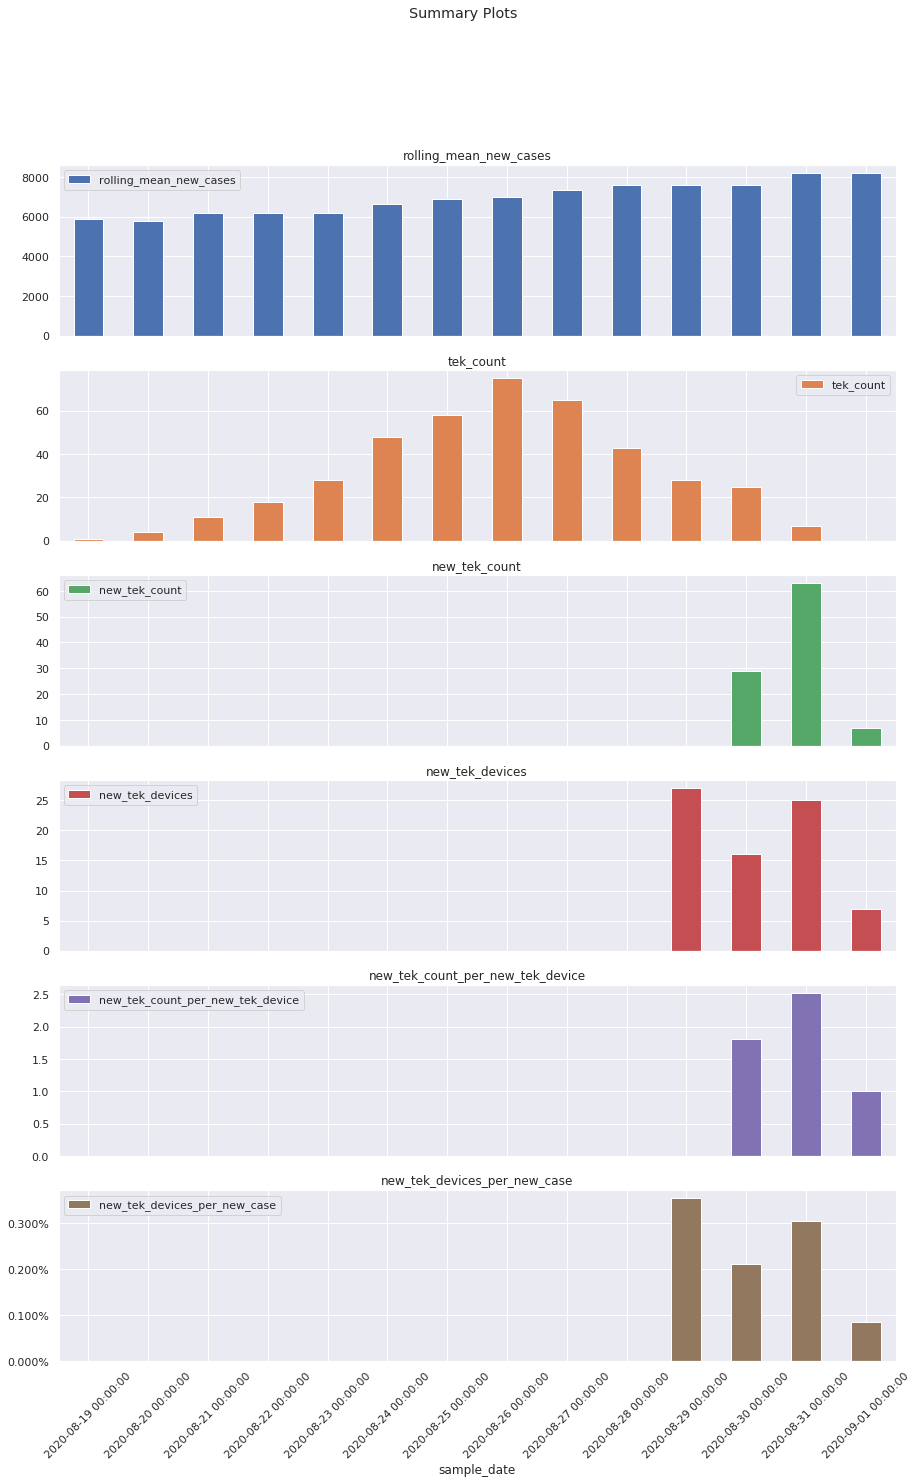

In [29]:
summary_ax_list = result_summary_df[[
    "rolling_mean_new_cases",
    "tek_count",
    "new_tek_count",
    "new_tek_devices",
    "new_tek_count_per_new_tek_device",
    "new_tek_devices_per_new_case"
]].sort_index(ascending=True).plot.bar(
    title="Summary Plots", rot=45, subplots=True, figsize=(15, 22))
summary_ax_list[-1].yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))

### Hourly Summary Plots 

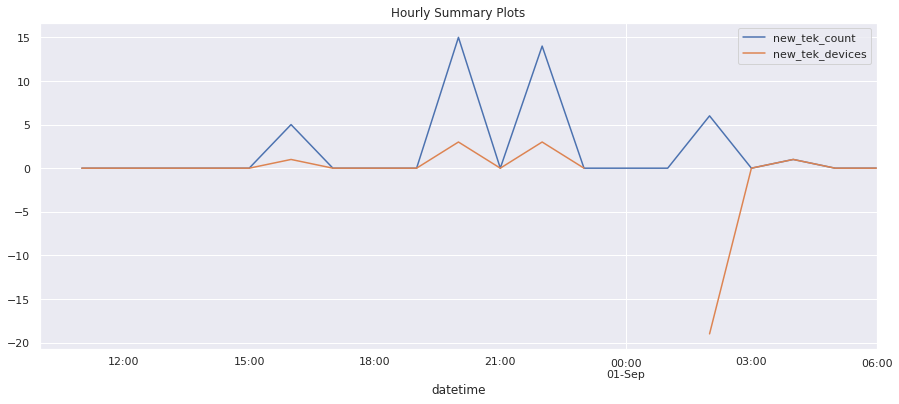

In [30]:
hourly_summary_ax = hourly_summary_df.plot(title="Hourly Summary Plots")

### Publish Results

In [31]:
def get_temporary_image_path() -> str:
    return os.path.join(tempfile.gettempdir(), str(uuid.uuid4()) + ".png")

def save_temporary_plot_image(ax):
    media_path = get_temporary_image_path()
    ax.get_figure().savefig(media_path)
    return media_path

def save_temporary_dataframe_image(df):
    media_path = get_temporary_image_path()
    dfi.export(df, media_path)
    return media_path

summary_plots_image_path = save_temporary_plot_image(ax=summary_ax_list[0])
summary_table_image_path = save_temporary_dataframe_image(df=result_summary_df)
hourly_summary_plots_image_path = save_temporary_plot_image(ax=hourly_summary_ax)

### Save Results

In [32]:
report_resources_path_prefix = "Data/Resources/Current/RadarCOVID-Report-"
result_summary_df.to_csv(report_resources_path_prefix + "Summary-Table.csv")
result_summary_df.to_html(report_resources_path_prefix + "Summary-Table.html")
_ = shutil.copyfile(summary_plots_image_path, report_resources_path_prefix + "Summary-Plots.png")
_ = shutil.copyfile(summary_table_image_path, report_resources_path_prefix + "Summary-Table.png")
_ = shutil.copyfile(hourly_summary_plots_image_path, report_resources_path_prefix + "Hourly-Summary-Plots.png")

report_daily_url_pattern = \
    "https://github.com/pvieito/RadarCOVID-Report/blob/master/Notebooks/" \
    "RadarCOVID-Report/{report_type}/RadarCOVID-Report-{report_date}.ipynb"
report_daily_url = report_daily_url_pattern.format(
    report_type="Daily", report_date=extraction_date)
report_hourly_url = report_daily_url_pattern.format(
    report_type="Hourly", report_date=extraction_date_with_hour)

### Publish on README

In [33]:
with open("Data/Templates/README.md", "r") as f:
    readme_contents = f.read()

summary_table_html = result_summary_df.to_html()
readme_contents = readme_contents.format(
    summary_table_html=summary_table_html,
    report_url_with_hour=report_hourly_url,
    extraction_date_with_hour=extraction_date_with_hour)

with open("README.md", "w") as f:
    f.write(readme_contents)

### Publish on Twitter

In [34]:
enable_share_to_twitter = os.environ.get("RADARCOVID_REPORT__ENABLE_PUBLISH_ON_TWITTER")
github_event_name = os.environ.get("GITHUB_EVENT_NAME")

if enable_share_to_twitter and github_event_name == "schedule":
    import tweepy

    twitter_api_auth_keys = os.environ["RADARCOVID_REPORT__TWITTER_API_AUTH_KEYS"]
    twitter_api_auth_keys = twitter_api_auth_keys.split(":")
    auth = tweepy.OAuthHandler(twitter_api_auth_keys[0], twitter_api_auth_keys[1])
    auth.set_access_token(twitter_api_auth_keys[2], twitter_api_auth_keys[3])

    api = tweepy.API(auth)

    summary_plots_media = api.media_upload(summary_plots_image_path)
    summary_table_media = api.media_upload(summary_table_image_path)
    hourly_summary_plots_media = api.media_upload(hourly_summary_plots_image_path)
    media_ids = [
        summary_plots_media.media_id,
        summary_table_media.media_id,
        hourly_summary_plots_media.media_id,
    ]

    extraction_date_result_summary_df = \
        result_summary_df[result_summary_df.index == extraction_date]
    extraction_date_result_hourly_summary_df = \
        hourly_summary_df[hourly_summary_df.extraction_date_with_hour == extraction_date_with_hour]

    new_teks = extraction_date_result_summary_df.new_tek_count.sum().astype(int)
    new_teks_last_hour = extraction_date_result_hourly_summary_df.new_tek_count.sum().astype(int)
    new_devices = extraction_date_result_summary_df.new_tek_devices.sum().astype(int)
    new_devices_last_hour = extraction_date_result_hourly_summary_df.new_tek_devices.sum().astype(int)
    new_tek_count_per_new_tek_device = \
        extraction_date_result_summary_df.new_tek_count_per_new_tek_device.sum()
    new_tek_devices_per_new_case = \
        extraction_date_result_summary_df.new_tek_devices_per_new_case.sum()

    status = textwrap.dedent(f"""
        Report Update – {extraction_date_with_hour}
        #ExposureNotification #RadarCOVID

        Shared Diagnoses Day Summary:
        - New TEKs: {new_teks} ({new_teks_last_hour:+d} last hour)
        - New Devices: {new_devices} ({new_devices_last_hour:+d} last hour, {new_tek_count_per_new_tek_device:.2} TEKs/device)
        - Usage Ratio: {new_tek_devices_per_new_case:.2%} devices/case

        Report Link: {report_hourly_url}
        """)
    status = status.encode(encoding="utf-8")
    api.update_status(status=status, media_ids=media_ids)